## Setup

In [ ]:
!pip install tinker
!pip install -q "chz"
!git clone https://github.com/thinking-machines-lab/tinker-cookbook.git
%cd tinker-cookbook
!pip install -q -e .
!pip install --upgrade transformers
!pip install -U "datasets>=2.19.0"
!pip install lm-eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.9 MB/s eta 0:00:00
Cloning into 'tinker-cookbook'...
remote: Enumerating objects: 2080, done.
remote: Counting objects: 100% (767/767), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 2080 (delta 699), reused 603 (delta 603), pack-reused 1313 (from 2)
Receiving objects: 100% (2080/2080), 1.17 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (1349/1349), done.
/content/tinker-cookbook
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 17.1 MB/s eta 0:00:00


In [ ]:
import asyncio
import logging
import os

import chz
import tinker
from tinker import types
from tinker_cookbook import checkpoint_utils, model_info, tokenizer_utils
from tinker_cookbook.preference.comparison_policy_evaluator import ComparisonEvaluator
from tinker_cookbook.preference.preference_datasets import ChatDatasetBuilderFromComparisons
from tinker_cookbook.preference.types import PreferenceModelBuilderFromChatRenderer
from tinker_cookbook.recipes.chat_sl.chat_datasets import NoRobotsBuilder
from tinker_cookbook.recipes.preference.datasets import HHHComparisonBuilder, ArenaComparisonBuilder, UltraFeedbackComparisonBuilder
from tinker_cookbook.renderers import TrainOnWhat
from tinker_cookbook.rl import preference_envs, train
from tinker_cookbook.supervised import train as supervised_train
from tinker_cookbook.supervised.types import ChatDatasetBuilderCommonConfig
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import random
import json
import urllib.request
import torch.nn.functional as F
from torch.nn.utils import prune

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')
BELLO_root = '/content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project'

root_folder = BELLO_root

Mounted at /content/drive


In [ ]:
import os
from huggingface_hub import login
from huggingface_hub.utils import disable_progress_bars

os.environ["TINKER_API_KEY"] = 
HUGGFACE_TOKEN = 
login(HUGGFACE_TOKEN)
disable_progress_bars()

In [ ]:
import torch
from typing import Dict, Optional
from dataclasses import dataclass
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()
import re

sparsity_levels = [.25, .50, .75]

@dataclass
class BaseModel:
  name: str
  description: Optional[str] = None

base_models = [
    BaseModel(name="meta-llama/Llama-3.2-1B"),
]

TORCH_DTYPE = torch.float16

In [ ]:
def get_tokenizer(base_model_name):
  tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side="right", fix_mistral_regex=True)

  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
  return tokenizer

def get_model_dir_name(base_model, sparsity, type_):
  """
  Convert:
      meta-llama/Llama-3.2-1B  +  sparsity=0.25
  into:
      Llama_3_2_1B_25
  """
  family, rest = base_model.name.split("/")  # rest = "Llama-3.2-1B"
  model_name, model_size = rest.split("-", 1)  # "Llama", "3.2-1B"
  model_size_clean = re.sub(r"[^0-9A-Za-z]+", "_", model_size)
  sparsity_int = int(sparsity * 100)
  model_dir_name = f"{model_name}_{model_size_clean}_{sparsity_int}_{type_ if not (type_ == None) else "Baseline"}"
  return model_dir_name

def get_directory_path(base_model, sparsity, type_):
  model_dir_name = get_model_dir_name(base_model, sparsity, type_)
  save_dir = os.path.join(root_folder, "Models", f"{model_dir_name}")
  return save_dir

## Reward Model Pruning

### 1. Training Reward Model

In [ ]:
@chz.chz
class CLIConfig:
    base_model: str
    short_name: str
    wandb_name: str | None = "RM"
    wandb_project: str | None = None
    lora_rank: int = 64
    max_length: int = 16384
    batch_size: int = 256

    rm_learning_rate: float = 3e-4

    save_every: int = 100
    eval_every: int = 20

    # Logtree configuration - number of groups to log per iteration (0 = disable)
    num_groups_to_log: int = 1

RewardModels = {
    "HH": HHHComparisonBuilder,
    "Arena": ArenaComparisonBuilder,
    "UltraFeedback": UltraFeedbackComparisonBuilder,
}

In [ ]:
def get_reward_model_name_and_path(reward_model_name, short_name):
  model_dir_name = f"{reward_model_name}-{cli_config.short_name}"
  save_dir = os.path.join(root_folder, "RewardModels", model_dir_name)
  return model_dir_name, save_dir

In [ ]:
async def train_rm(
    log_path: str,
    base_model: str,
    wandb_project: str | None,
    wandb_name: str | None,
    lora_rank: int,
    batch_size: int,
    learning_rate: float,
    max_length: int,
    save_every: int,
    eval_every: int,
    comparison_builder
):
    """Train reward model using Anthropic HHH preference comparisons."""
    # Use HHH comparison builder for Anthropic data
    comparison_builder = comparison_builder()

    # Get renderer name for the model
    renderer_name = model_info.get_recommended_renderer_name(base_model)

    # Create common config for the dataset builder
    common_config = ChatDatasetBuilderCommonConfig(
        model_name_for_tokenizer=base_model,
        renderer_name=renderer_name,
        max_length=max_length,
        batch_size=batch_size,
    )

    # Create the dataset builder that wraps comparisons with rendering
    dataset_builder = ChatDatasetBuilderFromComparisons(
        common_config=common_config, comparison_builder=comparison_builder
    )

    # Create training config
    config = supervised_train.Config(
        log_path=log_path,
        model_name=base_model,
        dataset_builder=dataset_builder,
        evaluator_builders=[],  # Could add evaluators here
        num_epochs=1,
        learning_rate=learning_rate,
        lr_schedule="linear",
        save_every=save_every,
        eval_every=eval_every,
        lora_rank=lora_rank,
        wandb_project=wandb_project,
        wandb_name=f"{wandb_name}-rm",
    )

    # Run training
    await supervised_train.main(config)

In [ ]:
async def cli_main(cli_config: CLIConfig, comparison_builder, model_dir_name, save_dir):
    model_dir_name = f"{reward_model_name}-{cli_config.short_name}"
    save_dir = os.path.join(root_folder, "RewardModels", model_dir_name)
    await train_rm(
        save_dir,
        cli_config.base_model,
        cli_config.wandb_project,
        model_dir_name,
        cli_config.lora_rank,
        cli_config.batch_size,
        cli_config.rm_learning_rate,
        cli_config.max_length,
        cli_config.save_every,
        cli_config.eval_every,
        comparison_builder
    )

In [ ]:
# logging.getLogger("tinker_cookbook").setLevel(logging.WARNING)
# logging.getLogger("tinker").setLevel(logging.WARNING)

for model in base_models:
  for reward_model_name, comparison_builder in RewardModels.items():
    cli_config = CLIConfig(
          base_model=model.name,
          short_name=model.name.split("/")[-1],  # optional but useful
    )

    rm_dir_name, save_dir = get_reward_model_name_and_path(reward_model_name, cli_config.short_name)

    if os.path.exists(save_dir):
      print(f"[Skip] {save_dir} already exists — continuing.")
      continue

    await cli_main(cli_config, comparison_builder, rm_dir_name, save_dir)
    print(f"[{rm_dir_name}] Done Training reward model ")

[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/HH-Llama-3.2-1B already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/Arena-Llama-3.2-1B already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/UltraFeedback-Llama-3.2-1B already exists — continuing.


### 2. Load Reward Model Locally

In [ ]:
# Download LORA adapters for the reward model from tinker
sc = tinker.ServiceClient()
rc = sc.create_rest_client()

for model in base_models:
    for reward_model_name, comparison_builder in RewardModels.items():
        short_name = model.name.split("/")[-1]
        rm_dir_name, save_dir = get_reward_model_name_and_path(reward_model_name, cli_config.short_name)
        out_path = os.path.join(save_dir, "sampler_archive.tar")

        if os.path.isfile(out_path):
          print(f"[Skip] {out_path} already exists — continuing.")
          continue

        # Path to checkpoints.jsonl for this (reward model, base model) combo
        checkpoints_path = os.path.join(save_dir, "checkpoints.jsonl")


        state_path = None
        # Read the jsonl file and look for the "final" checkpoint
        with open(checkpoints_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                rec = json.loads(line)

                # Prefer the explicitly named "final" checkpoint
                if rec.get("name") == "final":
                    state_path = rec["sampler_path"]

        # Fallback: if no explicit "final" entry, use the last checkpoint
        print(f"[info] downloading archive for: {rm_dir_name} from: {state_path}")

        future = rc.get_checkpoint_archive_url_from_tinker_path(state_path)
        resp = future.result()

        # Save archive inside this model's folder
        urllib.request.urlretrieve(resp.url, out_path)
        print(f"[DONE] Saved sampler archive to {out_path}")
        print()


[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/HH-Llama-3.2-1B/sampler_archive.tar already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/Arena-Llama-3.2-1B/sampler_archive.tar already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/UltraFeedback-Llama-3.2-1B/sampler_archive.tar already exists — continuing.


In [ ]:
# Combine the LORA adapters withe the model weights to get the reward model
import os, tarfile, urllib, json
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

for model in base_models:
  for reward_model_name, comparison_builder in RewardModels.items():
    rm_dir_name, save_dir = get_reward_model_name_and_path(reward_model_name, cli_config.short_name)

    # Extract adapter
    adapter_dir = os.path.join(save_dir, "adapter")
    if os.path.exists(adapter_dir):
        print(f"[Skip] {adapter_dir} already exists — continuing.")
        continue

    os.makedirs(adapter_dir, exist_ok=True)

    with tarfile.open(out_path, "r") as tar:
        tar.extractall(adapter_dir)
    print("[ok] extracted adapter to:", adapter_dir)

    # Load base LM + LoRA
    tokenizer = AutoTokenizer.from_pretrained(model.name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    base_model = AutoModelForCausalLM.from_pretrained(
        model.name,
        dtype=TORCH_DTYPE,
    )

    rm = PeftModel.from_pretrained(base_model, adapter_dir)
    rm = rm.merge_and_unload()

    # Save merged reward model
    merged_model_dir = os.path.join(save_dir, "merged_model")
    rm.save_pretrained(merged_model_dir)
    tokenizer.save_pretrained(merged_model_dir)

    print("[DONE] merged model saved to:", merged_model_dir)
    print()


[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/HH-Llama-3.2-1B/adapter already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/Arena-Llama-3.2-1B/adapter already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/RewardModels/UltraFeedback-Llama-3.2-1B/adapter already exists — continuing.


### 3. Calibration Datasets

In [ ]:
hh_dataset = load_dataset("Anthropic/hh-rlhf", split="train")
arena_dataset = load_dataset("lmsys/lmsys-chat-1m", split="train")
uf_dataset = load_dataset("openbmb/UltraFeedback", split="train")

# --- Helper for safe sampling ---
def safe_sample(ds, k):
    n = min(len(ds), k)
    idx = random.sample(range(len(ds)), n)
    return [ds[i] for i in idx]

NUM_SAMPLES = 128

In [ ]:
import random
import re

def sample_hh_policy_prompts(
    n_samples: int,
    seed: int = 42,
):
    """
    Sample `n_samples` policy prompts from Anthropic HH-RLHF.

    For each row:
      - Start from `chosen` (full Human/Assistant conversation as text)
      - Parse into chat-style messages
      - Drop the *final* assistant answer so the last turn is a user
      - Return messages in [{"role": "...", "content": "..."}, ...] format

    These message lists are meant to be passed through a chat renderer
    (e.g., tokenizer.apply_chat_template(..., add_generation_prompt=True)).
    """
    random.seed(seed)

    hh_samples = safe_sample(hh_dataset, n_samples)
    print("Example raw HH sample:\n", hh_samples[0], "\n")

    prompts = []

    # Anthropic-style headers: "\n\nHuman:" or "\n\nAssistant:"
    pattern = re.compile(r"\n\n(Human|Assistant):")

    for ex in hh_samples:
        raw = ex["chosen"]
        if not isinstance(raw, str):
            continue

        # IMPORTANT: don't strip leading "\n\nHuman:" or we break the regex
        raw = raw.rstrip()  # only trim the end, not the start

        parts = pattern.split(raw)
        # parts looks like: [prefix, Role1, Text1, Role2, Text2, ..., maybe_tail]

        messages = []

        # Roles are at indexes 1, 3, 5, ...; texts at 2, 4, 6, ...
        for i in range(1, len(parts), 2):
            role_tag = parts[i]
            text = parts[i + 1].strip()
            role = "user" if role_tag == "Human" else "assistant"
            messages.append({"role": role, "content": text})

        # Drop the final assistant answer; we want the policy to regenerate it
        if messages[-1]["role"] == "assistant":
            messages = messages[:-1]

        # We only want examples that end on a user turn
        if not messages or messages[-1]["role"] != "user":
            continue

        prompts.append(messages)

    print("Example HH policy prompt (chat format):\n", prompts[0], "\n")
    return prompts


In [ ]:
hh_prompts = sample_hh_policy_prompts(NUM_SAMPLES)

Example raw HH sample:
 {'chosen': "\n\nHuman: What's your favorite sexual position?\n\nAssistant: It depends on a lot of factors. If it’s going to be easy, maybe missionary style is easiest.  It doesn’t require much flexibility, so it’s good for beginners.  But sometimes when I’m in the mood for a deep, intense experience, I’ll switch it up and do cowgirl or reverse cowgirl, because those positions are the most likely to help stimulate a lot of different parts of your body.\n\nHuman: Be more specific?\n\nAssistant: More specifically, I have to explain that cowgirl involves your partner being on the bottom, and you are riding him.  Reverse cowgirl has you on the bottom, but he's doing the cowgirl, which is the woman riding a man like you're on top, except he's in front.", 'rejected': "\n\nHuman: What's your favorite sexual position?\n\nAssistant: It depends on a lot of factors. If it’s going to be easy, maybe missionary style is easiest.  It doesn’t require much flexibility, so it’s go

In [ ]:
import random

def sample_arena_policy_prompts(
    n_samples: int = 128,
    seed: int = 42,
):
    """
    Sample `n_samples` policy prompts from the Arena dataset.

    Assumptions:
      - Format is ALWAYS: User -> Assistant
      - We DROP the assistant answer
      - We return only a *single-user* message in chat format:

            [
              {"role": "user", "content": "<user content>"}
            ]

    These message lists can be fed into a chat renderer
    (e.g., tokenizer.apply_chat_template or a Tinker dataset builder)
    to produce the actual text prompt for the policy LLM.
    """
    random.seed(seed)

    arena_samples = safe_sample(arena_dataset, n_samples)
    print("Example raw Arena sample:\n", arena_samples[0], "\n")

    prompts = []

    for ex in arena_samples:
        conv = ex["conversation"]
        # Store as a chat-style list of messages
        chat_messages = conv[:-1]
        prompts.append(chat_messages)

    print("Example Arena policy prompt (chat format):\n", prompts[0], "\n")
    return prompts

In [ ]:
arena_prompts = sample_arena_policy_prompts(NUM_SAMPLES)

Example raw Arena sample:
 {'conversation_id': 'dc30947501c244a495d5cd0584e9b587', 'model': 'stablelm-tuned-alpha-7b', 'conversation': [{'content': "expand the following to a story - 'he saw the moon, but it looked rather odd.'\n", 'role': 'user'}, {'content': "Once upon a time, on a clear and starry night, there was a young boy named NAME_1 who saw the moon shining brightly in the sky. He couldn't believe his eyes as he had never seen anything like it before. The moon was so big and bright that it looked like a giant red and white mushroom.\n\nNAME_1's father noticed that his son was staring at the moon and asked him what he was looking at. NAME_1 explained that he was looking at the moon, but it looked rather odd. His father explained that it was just his imagination and that the moon was actually a mirage.\n\nThe boy's father was not convinced and decided to take him to the beach to show him the real moon. As they walked along the beach, NAME_1 realized that the moon was much bigger

In [ ]:
import random

def sample_uf_policy_prompts(
    n_samples: int = 128,
    seed: int = 42,
):
    """
    Sample `n_samples` policy prompts from the UltraFeedback (UF) dataset.

    Assumptions:
      - Each UF sample contains a single user instruction in:
            ex["instruction"]
      - We IGNORE completions, critiques, scores, etc.
      - We return only a *single-user* message in chat format:

            [
              {"role": "user", "content": "<instruction>"}
            ]

    These message lists can be fed into a chat renderer
    (e.g., tokenizer.apply_chat_template or a Tinker dataset builder)
    to produce the actual text prompt for the policy LLM.
    """
    random.seed(seed)

    uf_samples = safe_sample(uf_dataset, n_samples)
    print("Example raw UF sample:\n", uf_samples[0], "\n")

    prompts = []

    for ex in uf_samples:
        # UF uses "instruction" as the user query
        user_msg = ex["instruction"].strip()

        chat_messages = [
            {"role": "user", "content": user_msg}
        ]

        prompts.append(chat_messages)

    print("Example UF policy prompt (chat format):\n", prompts[0], "\n")
    return prompts

In [ ]:
uf_prompts = sample_uf_policy_prompts(NUM_SAMPLES)

Example raw UF sample:
 {'source': 'sharegpt', 'instruction': 'how to say someone is better without saying smoeone is better', 'models': ['alpaca-7b', 'ultralm-65b', 'wizardlm-13b', 'wizardlm-70b'], 'completions': [{'annotations': {'helpfulness': {'Rating': '3', 'Rationale': 'The response is clear and relevant, providing useful information. However, it is not as comprehensive as it could be.', 'Rationale For Rating': 'The text is correct and provides useful information, but it lacks the depth and variety of examples found in Text 1.', 'Type': ['1', '2']}, 'honesty': {'Rating': '3', 'Rationale': 'The text is confident but contains subtle mistakes, as the provided phrases still imply direct comparison and may not be the most diplomatic way to convey the idea.'}, 'instruction_following': {'Rating': '3', 'Rationale': 'The text provides examples of phrases that imply someone is better, but the examples are not as indirect or diplomatic as the instruction requires. It partially meets the tas

In [ ]:
calibration_dataset = {
  "HH": hh_prompts,
  "Arena": arena_prompts,
  "UltraFeedback": uf_prompts
}

### 4. Model Pruning

In [ ]:
def register_activation_hooks(model: nn.Module):
    """
    Register forward hooks on Linear (and Conv2d) modules to capture their inputs.

    Returns:
        activations: dict[name -> Tensor], storing the *last* input seen for each module
        handles: list of hook handles (so you can remove them later)
    """
    activations = {}
    handles = []

    def _make_hook(name):
        def hook(module, inp, _out):
            # inp is a tuple; inp[0] is the input tensor
            # Detach to avoid holding onto the graph
            activations[name] = inp[0].detach()
        return hook

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            h = module.register_forward_hook(_make_hook(name))
            handles.append(h)

    return activations, handles

In [ ]:
@dataclass
class CompletionGroup:
    """
    Holds data for one prompt and its group_size completions.
    """
    prompt_text: str
    prompt_ids: torch.LongTensor          # [Tp]
    resp_texts: list[str]                # length = group_size
    resp_ids: list[torch.LongTensor]     # each [Tr]


In [ ]:
def generate_group_completions(
    policy_model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    prompts: list[list[dict]],  # list of chat-message lists
    desc: str,
    group_size: int,
    max_new_tokens: int,
    temperature: float,
    top_k: int,
) -> list[CompletionGroup]:
    """
    prompts: list of conversations, where each conversation is
             a list[{"role": ..., "content": ...}, ...]

    For each conversation, sample `group_size` completions
    from the policy model. Returns one CompletionGroup per prompt.
    """
    device = next(policy_model.parameters()).device
    groups: List[CompletionGroup] = []
    eot_id = tokenizer.convert_tokens_to_ids("<|eot_id|>")

    for messages in tqdm(prompts, desc=f"Generating group completions | {desc}"):
        # 1) Render the chat into a prompt string (nice for logging / debugging)
        prompt_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
        )

        # 2) Tokenize that prompt for the model
        enc = tokenizer(
            prompt_text,
            return_tensors="pt",
            add_special_tokens=False,
        )
        input_ids = enc["input_ids"].to(device)        # shape: [1, T]
        attention_mask = enc["attention_mask"].to(device)
        prompt_len = input_ids.shape[1]

        resp_texts: list[str] = []
        resp_ids: list[torch.Tensor] = []

        # 3) Sample group_size completions independently
        for _ in range(group_size):
            out = policy_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_k=top_k,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=[tokenizer.eos_token_id, eot_id],
            )
            # Tokens after the prompt
            gen_tokens = out[:, prompt_len:]          # shape [1, T_gen]
            gen_tokens_0 = gen_tokens[0]

            resp_ids.append(gen_tokens_0.detach().cpu())
            resp_texts.append(
                tokenizer.decode(gen_tokens_0, skip_special_tokens=True)
            )

        groups.append(
            CompletionGroup(
                prompt_text=prompt_text,
                prompt_ids=input_ids[0].detach().cpu(),
                resp_texts=resp_texts,
                resp_ids=resp_ids,
            )
        )

    return groups

In [ ]:
def build_all_pairs(num_items: int) -> list[tuple[int, int]]:
    """
    Simple version of get_pairs_chunked:
    return all (i, j) with i < j.
    """
    pairs = []
    for i in range(num_items):
        for j in range(i + 1, num_items):
            pairs.append((i, j))
    return pairs


In [ ]:
def rm_compare_pair(
    rm_model: AutoModelForCausalLM,
    rm_tokenizer: AutoTokenizer,
    prompt_text: str,
    completion_i: str,
    completion_j: str,
    max_input_length: int = 2048,
) -> float:
    """
    Approximate the behavior of PreferenceModelFromChatRenderer:
    - Build a comparison prompt with A/B/Tie structure
    - Generate one token with temperature=0.0
    - Map A/B/Tie -> -1, +1, 0
    """
    device = next(rm_model.parameters()).device

    text = (
        prompt_text
        + "\n==== Completion A ====\n"
        + completion_i
        + "\n==== Completion B ====\n"
        + completion_j
        + "\n==== Preference ====\n"
    )

    enc = rm_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
    ).to(device)

    with torch.no_grad():
        out = rm_model.generate(
            **enc,
            max_new_tokens=1,
            do_sample=False,      # temperature=0.0
            pad_token_id=rm_tokenizer.eos_token_id,
        )

    new_tokens = out[0, enc["input_ids"].shape[1]:]
    s = rm_tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    if s == "A":
        return -1.0
    elif s == "B":
        return 1.0
    elif s == "Tie":
        return 0.0
    else:
        # Unknown token: treat as tie / 0
        return 0.0


In [ ]:
def compute_group_rewards_for_prompt(
    rm_model: AutoModelForCausalLM,
    rm_tokenizer: AutoTokenizer,
    group: CompletionGroup,
) -> list[float]:
    """
    Given a CompletionGroup (one prompt + group_size completions),
    compute a scalar reward per completion using the same logic as
    Tinker's PairwisePreferenceGroupBuilder.compute_group_rewards.

    For simplicity, we set is_valid=True for all completions.
    """
    K = len(group.resp_texts)
    if K == 0:
        return []

    # Pairwise index pairs
    pairs = build_all_pairs(K)  # [(i, j), ...]

    # Pairwise rewards for "j vs i"
    j_rewards = []
    for (i, j) in pairs:
        r = rm_compare_pair(
            rm_model,
            rm_tokenizer,
            prompt_text=group.prompt_text,
            completion_i=group.resp_texts[i],
            completion_j=group.resp_texts[j],
        )
        j_rewards.append(r)

    # Aggregate into win_minus_loss and matchup_count, as Tinker does
    win_minus_loss_list = [0.0 for _ in range(K)]
    matchup_count = [0 for _ in range(K)]

    for (i, j), j_reward in zip(pairs, j_rewards, strict=True):
        win_minus_loss_list[j] += j_reward
        win_minus_loss_list[i] -= j_reward
        matchup_count[j] += 1
        matchup_count[i] += 1

    # You can do actual format checks; here we assume all valid
    is_valid_list = [True for _ in range(K)]
    format_coef = 1.0

    rewards = []
    for win_minus_loss, is_valid, count in zip(
        win_minus_loss_list, is_valid_list, matchup_count, strict=True
    ):
        pref_score = win_minus_loss / count

        # format term: (float(is_valid) - 1.0) -> 0 if valid, -1 if invalid
        format_term = format_coef * (float(is_valid) - 1.0)
        reward_k = pref_score + format_term
        rewards.append(reward_k)

    return rewards   # length = K


In [ ]:
def compute_all_group_rewards(
    rm_model: AutoModelForCausalLM,
    rm_tokenizer: AutoTokenizer,
    groups: list[CompletionGroup],
    desc: str
) -> list[list[float]]:
    """
    For each CompletionGroup in `groups`, compute a list of rewards
    (one scalar per completion).
    """
    all_rewards: list[list[float]] = []
    for group in tqdm(groups, desc=f"Computing rewards per completion group | {desc}"):
        rewards = compute_group_rewards_for_prompt(rm_model, rm_tokenizer, group)
        all_rewards.append(rewards)
    return all_rewards


In [ ]:
def seq_logprob_for_completion(
    policy_model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    prompt_ids: torch.LongTensor,   # [Tp]
    resp_ids: torch.LongTensor,     # [Tr]
) -> torch.Tensor:
    """
    Compute total log-prob of the response continuation given the prompt.
    Returns a scalar tensor.
    """
    device = next(policy_model.parameters()).device

    inp = torch.cat([prompt_ids, resp_ids], dim=0).unsqueeze(0).to(device)  # [1, Tp+Tr]
    logits = policy_model(input_ids=inp).logits[:, :-1]                   # [1, T-1, V]
    logprobs_all = F.log_softmax(logits, dim=-1)                          # [1, T-1, V]

    targets = inp[:, 1:]                                                  # [1, T-1]
    lp = logprobs_all.gather(-1, targets.unsqueeze(-1)).squeeze(-1)       # [1, T-1]
    Tp = prompt_ids.shape[0]
    resp_lp = lp[:, Tp-1:].sum(dim=-1)                                      # [1]
    return resp_lp.squeeze(0)                                             # scalar


In [ ]:
def rl_loss_from_groups(
    policy_model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    groups: list[CompletionGroup],
    all_rewards: list[list[float]],
) -> torch.Tensor:
    """
    Build a sequence-level REINFORCE-style loss:
        L = -mean_k [ advantage_k * log pi(c_k | prompt) ]
    where advantage_k is per-completion, centered within each group (prompt).

    Args:
        groups:       list of CompletionGroup
        all_rewards:  list of reward lists, same shape as groups
    """
    assert len(groups) == len(all_rewards)
    device = next(policy_model.parameters()).device

    logprob_list = []
    advantage_list = []

    for group, rewards_group in zip(groups, all_rewards, strict=True):
        # rewards_group: list[float], length K
        rewards_tensor = torch.tensor(rewards_group, dtype=torch.float32, device=device)
        advantages_group = rewards_tensor - rewards_tensor.mean()  # center per prompt

        for k, (resp_ids_k, adv_k) in enumerate(zip(group.resp_ids, advantages_group, strict=True)):
            logp_k = seq_logprob_for_completion(
                policy_model,
                tokenizer,
                group.prompt_ids,
                resp_ids_k,
            )
            logprob_list.append(logp_k)
            advantage_list.append(adv_k)

    logprobs = torch.stack(logprob_list)        # [N_completions]
    advantages = torch.stack(advantage_list)    # [N_completions]

    # REINFORCE objective: maximize E[adv * logpi]
    # Loss = -mean(adv * logpi)
    loss = -(advantages * logprobs).mean()
    return loss


In [ ]:
def collect_group_grads_glp_style(
    policy_model: AutoModelForCausalLM,
    policy_tokenizer: AutoTokenizer,
    groups: list[CompletionGroup],
    all_rewards: list[list[float]],
    activations: dict[str, torch.Tensor],
    desc: str,
    gradient_p_norm: float = 1.0,
) -> dict[str, torch.Tensor]:
    """
    Collect GLP-style *group-level* gradient information, but in an
    online / memory-efficient way.

    Instead of storing [G, out, in] for each layer, we maintain:

        S[name][i,j] = sum_g |grad_g[i,j]|^p

    with p = gradient_p_norm (1 by default).

    At the end, we return dict[name -> S[name]], and the actual
    ||G[:,i,j]||_p can be recovered as S[name] ** (1/p).
    """
    device = next(policy_model.parameters()).device
    SKIP = {"embed_tokens", "lm_head", "rotary_emb"}

    # Initialize accumulators lazily after we see first grads
    grad_p_sums: dict[str, torch.Tensor] = {}

    for group, rewards_group in tqdm(
        list(zip(groups, all_rewards, strict=True)),
        desc=f"Collecting group-level gradients | {desc}",
    ):
        # rewards_group: list[float], length K
        rewards = torch.tensor(rewards_group, dtype=torch.float32, device=device)
        advantages = rewards - rewards.mean()   # GRPO-style baseline per group

        # ---- reset grads + activations for THIS GROUP ----
        policy_model.zero_grad(set_to_none=True)
        activations.clear()

        # ---- build group loss over all completions ----
        group_loss = 0.0
        K = 0

        for resp_ids_k, adv_k in zip(group.resp_ids, advantages, strict=True):
            logp_k = seq_logprob_for_completion(
                policy_model,
                policy_tokenizer,
                group.prompt_ids.to(device),
                resp_ids_k.to(device),
            )
            group_loss = group_loss - (adv_k * logp_k)
            K += 1

        if K == 0:
            continue

        group_loss = group_loss / K

        # ---- backward: gradient for THIS GROUP ----
        group_loss.backward()

        # ---- accumulate |grad|^p per layer ----
        for name, module in policy_model.named_modules():
            if (
                not isinstance(module, nn.Linear)
                or any(s in name for s in SKIP)
                or module.weight.grad is None
            ):
                continue

            g = module.weight.grad.detach()

            if name not in grad_p_sums:
                # Initialize accumulator on same device / dtype
                grad_p_sums[name] = torch.zeros_like(g, device=g.device)

            if gradient_p_norm == 1.0:
                grad_p_sums[name] += g.abs()
            else:
                grad_p_sums[name] += g.abs().pow(gradient_p_norm)

    return grad_p_sums

In [ ]:
def compute_glp_scores(
    model: nn.Module,
    activations: dict[str, torch.Tensor],
    group_grads: dict[str, torch.Tensor],  # now stores aggregated |grad|^p
    activation_p_norm: float,
    gradient_p_norm: float,
    alpha: float,
    desc: str
) -> dict[str, torch.Tensor]:
    """
    GLP-style scores with online gradient norms.

    We assume group_grads[name] contains:

        S[name][i,j] = sum_g |grad_g[i,j]|^p

    with p = gradient_p_norm. Then:

        g_norm = S ** (1/p)

    and we compute:

        score[i,j] = |W[i,j]| * (alpha * g_norm[i,j] + ||X[:, j]||_2)
    """
    scores: dict[str, torch.Tensor] = {}
    SKIP = {"embed_tokens", "lm_head", "rotary_emb"}

    for name, module in tqdm(model.named_modules(), desc=f"Computing scores | {desc}"):
        if (
            not isinstance(module, nn.Linear)
            or name not in activations
            or name not in group_grads
            or any(s in name for s in SKIP)
        ):
            continue

        W   = module.weight               # [out, in]
        X   = activations[name]           # [B, in] or [B, T, in]
        S   = group_grads[name]           # [out, in], aggregated |grad|^p

        # ---- activations term: ||X[:, j]||_2 over tokens/examples ----
        if X.dim() == 2:
            x_flat = X                    # [N_tokens, in]
        elif X.dim() == 3:
            x_flat = X.reshape(-1, X.shape[-1])  # [N_tokens, in]
        else:
            # unexpected shape, skip this module
            continue

        x_norm = torch.linalg.norm(x_flat, ord=activation_p_norm, dim=0)   # [in]
        x_norm_expanded = x_norm.unsqueeze(0).expand_as(W)                 # [out, in]

        # ---- gradient term: ||G_group[:, i, j]||_p ----
        if gradient_p_norm == 1.0:
            g_norm = S
        else:
            g_norm = S.clamp_min(0).pow(1.0 / gradient_p_norm)

        W_abs = W.abs()
        score = W_abs * (alpha * g_norm + x_norm_expanded)   # [out, in]
        scores[name] = score

    return scores

In [ ]:
def apply_glp_masks(
    model: nn.Module,
    scores: dict[str, torch.Tensor],
    sparsity: float,
    desc: str
):
    """
    Apply global pruning based on GLP scores.

    Args:
        model:    the policy model to prune
        scores:   dict[name -> score tensor] from compute_glp_scores
        sparsity: fraction of weights to prune globally (0.0 - 1.0)
    """
    # Concatenate all scores into a single vector
    all_scores = torch.cat([s.flatten() for s in scores.values()])

    n_params = all_scores.numel()
    k = int(sparsity * n_params)

    if k <= 0:
        return

    # Threshold: the largest score among the k smallest scores
    # (so everything <= threshold will be pruned)
    threshold = torch.topk(all_scores, k, largest=False).values.max().item()
    # Apply masks per module
    for name, module in tqdm(model.named_modules(), desc=f"Pruning model | {desc}, {sparsity}"):
        if name not in scores:
            continue
        s = scores[name].to(module.weight.device)
        mask = (s > threshold).to(dtype=TORCH_DTYPE, device=module.weight.device)
        prune.custom_from_mask(module, name="weight", mask=mask)
        prune.remove(module, "weight")


In [ ]:
@dataclass
class PruningConfig:
  group_size: str = 4
  max_new_tokens: int = 128
  activation_p_norm: int = 2
  gradient_p_norm: int = 1
  top_k: int  = 50
  temperature: float = 1.0
  alpha: float = 1.0

pruning_config = PruningConfig()

In [ ]:
def get_pruning_scores(
    policy_model: AutoModelForCausalLM,
    policy_tokenizer: AutoTokenizer,
    reward_model_name: str,
    base_model: BaseModel,
    config: PruningConfig
):
  """
  Get teh GLP pruning scores:

  1) Generate group_size completions per prompt with policy_model.
  2) Compute Tinker-style per-completion rewards with rm_model.
  3) Compute sequence-level RL loss and backprop to get gradients.
  4) Use gradients + activations to compute GLP scores.
  """
  reward_model, rm_tokenizer = get_reward_model_and_tokenizer(reward_model_name, base_model)
  pruning_prompts = calibration_dataset[reward_model_name]

  # 0) Register hooks to capture activations X during RL loss forward pass
  activations, hooks = register_activation_hooks(policy_model)

  # 1) Generate completions with the policy
  groups = generate_group_completions(
      policy_model=policy_model,
      tokenizer=policy_tokenizer,
      prompts=pruning_prompts,
      desc=reward_model_name,
      group_size=pruning_config.group_size,
      max_new_tokens=pruning_config.max_new_tokens,
      temperature=pruning_config.temperature,
      top_k=pruning_config.top_k,
  )

  # 2) Compute Tinker-style rewards per completion
  all_rewards = compute_all_group_rewards(
      rm_model=reward_model,
      rm_tokenizer=rm_tokenizer,
      groups=groups,
      desc=reward_model_name,
  )

  # 3) Compute RL loss and backprop to get gradients
  policy_model.train()

  per_sample_grads = collect_group_grads_glp_style(
        policy_model=policy_model,
        policy_tokenizer=policy_tokenizer,
        groups=groups,
        all_rewards=all_rewards,
        activations=activations,
        desc=reward_model_name,
        gradient_p_norm=config.gradient_p_norm,
  )

  # 4) Compute GLP scores and apply pruning masks
  scores = compute_glp_scores(
      model=policy_model,
      activations=activations,
      group_grads=per_sample_grads,
      activation_p_norm=config.activation_p_norm,
      gradient_p_norm=config.gradient_p_norm,
      alpha=config.alpha,
      desc=reward_model_name,
  )
  return scores, hooks

In [ ]:
def get_reward_model_and_tokenizer(reward_model_name, base_model):
  """Load merged reward model produced earlier"""
  base_model_name = base_model.name
  rm_dir_name, save_dir = get_reward_model_name_and_path(reward_model_name, base_model_name.split("/")[-1])
  reward_model_path = os.path.join(save_dir, "merged_model")

  reward_model = AutoModelForCausalLM.from_pretrained(reward_model_path, dtype=TORCH_DTYPE, device_map="auto")
  rm_tokenizer = AutoTokenizer.from_pretrained(reward_model_path, fix_mistral_regex=True)
  return reward_model, rm_tokenizer

In [ ]:
for model in base_models:
  for reward_model_name, _ in RewardModels.items():
    # Skip reward model pruning if done for all sparsity levels
    all_computed = True
    for sparsity in sparsity_levels:
      save_dir = get_directory_path(model, sparsity, reward_model_name)
      if not os.path.exists(save_dir):
        all_computed = False

    if (all_computed):
        print(f"[Skip] pruned model with {reward_model_name} already exists for all sparsity levels — continuing.")
        continue

    # Model and tokenizer
    tokenizer = get_tokenizer(model.name)
    tokenizer.chat_template = tokenizer.chat_template = (
      "{% for message in messages %}"
      "{% if loop.first %}{{ bos_token }}{% endif %}"
      "{{ '<|start_header_id|>' ~ message['role'] ~ '<|end_header_id|>\\n\\n' "
      "~ message['content'] ~ '<|eot_id|>' }}"
      "{% endfor %}"
      "{% if add_generation_prompt %}"
      "{{ '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}"
      "{% endif %}"
    )

    model_module = AutoModelForCausalLM.from_pretrained(
        model.name,
        dtype=TORCH_DTYPE,
        token=HUGGFACE_TOKEN
      ).to("cuda")

    scores, hooks = get_pruning_scores(
      policy_model=model_module,
      policy_tokenizer=tokenizer,
      reward_model_name=reward_model_name,
      base_model=model,
      config=pruning_config
    )

    for sparsity in sparsity_levels:
      save_dir = get_directory_path(model, sparsity, reward_model_name)
      if os.path.exists(save_dir):
        print(f"[Skip] {save_dir} already exists — continuing.")
        continue

      apply_glp_masks(
        model=model_module,
        scores=scores,
        sparsity=sparsity,
        desc=reward_model_name,
      )

      # Save pruned model
      os.makedirs(save_dir, exist_ok=True)
      model_module.save_pretrained(save_dir)
      tokenizer.save_pretrained(save_dir)
      print("[DONE] GLP-pruned model saved to:", save_dir)

    # Always remove hooks to avoid memory leaks
    for h in hooks:
        h.remove()

[Skip] pruned model with HH already exists for all sparsity levels — continuing.
[Skip] pruned model with Arena already exists for all sparsity levels — continuing.
[Skip] pruned model with UltraFeedback already exists for all sparsity levels — continuing.


## Magnitude Pruning

In [ ]:
def compute_magnitude_scores(model: nn.Module) -> dict[str, torch.Tensor]:
    SKIP = {"embed_tokens", "lm_head", "rotary_emb"}
    scores: dict[str, torch.Tensor] = {}

    for name, module in model.named_modules():
        if not isinstance(module, nn.Linear):
            continue
        if any(s in name for s in SKIP):
            continue
        scores[name] = module.weight.detach().abs().clone()  # [out, in]

    return scores


def apply_global_magnitude_pruning(model: nn.Module, sparsity: float):
    scores = compute_magnitude_scores(model)
    if not scores:
        return

    # flatten all |W| into one vector
    all_scores = torch.cat([s.flatten() for s in scores.values()])
    n_params = all_scores.numel()
    k = int(sparsity * n_params)
    if k <= 0:
        return

    # global threshold: k-th smallest |W|
    threshold = torch.topk(all_scores, k, largest=False).values.max().item()

    # apply masks
    for name, module in model.named_modules():
        if name not in scores:
            continue
        s = scores[name].to(module.weight.device)
        mask = (s > threshold).to(dtype=torch.float32, device=module.weight.device)
        prune.custom_from_mask(module, name="weight", mask=mask)
        prune.remove(module, "weight")

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MAGNITUDE_TYPE = "Magnitude"
for model in base_models:
  for sparsity in sparsity_levels:
    save_dir = get_directory_path(model, sparsity, MAGNITUDE_TYPE)
    # Model has already been pruned
    if os.path.exists(save_dir):
      print(f"[Skip] {save_dir} already exists — continuing.")
      continue

    tokenizer = get_tokenizer(model.name)
    model_module = AutoModelForCausalLM.from_pretrained(
        model.name,
        dtype=TORCH_DTYPE,
        token=HUGGFACE_TOKEN
      )
    model_module.to("cuda")
    apply_global_magnitude_pruning(model_module, sparsity=sparsity)

    # Save the pruned model
    os.makedirs(save_dir, exist_ok=True)
    model_module.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    print("Pruned model saved to: ", save_dir)

[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/Models/Llama_3_2_1B_25_Magnitude already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/Models/Llama_3_2_1B_50_Magnitude already exists — continuing.
[Skip] /content/drive/MyDrive/MIT/5. M.Eng/2. Fall 2025/6.7960/Final Project/Models/Llama_3_2_1B_75_Magnitude already exists — continuing.


## Evaluation

In [ ]:
import json, os
from typing import Any, Dict

EVAL_FILE = os.path.join(
    root_folder,
    "Evaluation/eval_results.json"
  )
os.makedirs(os.path.dirname(EVAL_FILE), exist_ok=True)

def load_eval_db() -> Dict[str, Dict[str, Any]]:
    if not os.path.exists(EVAL_FILE):
        return {}
    with open(EVAL_FILE, "r") as f:
        return json.load(f)

def save_eval_db(db: Dict[str, Dict[str, Any]]) -> None:
    with open(EVAL_FILE, "w") as f:
        json.dump(db, f, indent=2)

eval_db = load_eval_db()

In [ ]:
from dataclasses import dataclass

@dataclass
class ModelEvaluation:
  base_model: BaseModel
  sparsity: float
  type_: str = None
  model_path: Optional[str] = None

  # Metrics
  perplexity: Optional[float] = None
  zero_shot: Optional[Dict[str, Optional[float]]] = None

  @property
  def eval_id(self) -> str:
      """
      Unique key for this model variant in the eval store.
      """
      return get_model_dir_name(self.base_model, self.sparsity, self.type_)

  def __repr__(self):
    return self.eval_id

types = [MAGNITUDE_TYPE, *RewardModels]
eval_models = []
for base_model in base_models:
  eval_models.append(ModelEvaluation(base_model=base_model, sparsity=0))
  for type_ in types:
    for sparsity in sparsity_levels:
        model_path = get_directory_path(base_model, sparsity, type_)
        eval_models.append(ModelEvaluation(base_model=base_model, model_path=model_path, sparsity=sparsity, type_=type_))

print("eval_models: ", eval_models)

eval_models:  [Llama_3_2_1B_0_Baseline, Llama_3_2_1B_25_Magnitude, Llama_3_2_1B_50_Magnitude, Llama_3_2_1B_75_Magnitude, Llama_3_2_1B_25_HH, Llama_3_2_1B_50_HH, Llama_3_2_1B_75_HH, Llama_3_2_1B_25_Arena, Llama_3_2_1B_50_Arena, Llama_3_2_1B_75_Arena, Llama_3_2_1B_25_UltraFeedback, Llama_3_2_1B_50_UltraFeedback, Llama_3_2_1B_75_UltraFeedback]


In [ ]:
from transformers import AutoTokenizer

def get_model_and_tokenizer(eval_model: ModelEvaluation):
    """
    Returns (model, tokenizer) where:
    - model: AutoModelForCausalLM
    - tokenizer: AutoTokenizer

    Behavior:
    - If eval_model.model_path exists → load pruned model locally
    - Else → download the base pretrained model locally
    """
    base_model_name = eval_model.base_model.name
    tokenizer = get_tokenizer(base_model_name)
    # local pruned model
    if eval_model.model_path is not None and os.path.exists(eval_model.model_path):
      model = AutoModelForCausalLM.from_pretrained(
          eval_model.model_path,
          dtype=TORCH_DTYPE,
          device_map="auto"
      )

      return model, tokenizer
    # unpruned model
    else:
      model = AutoModelForCausalLM.from_pretrained(
          base_model_name,
          dtype=TORCH_DTYPE,
          device_map="auto"
      )
      return model, tokenizer

#### Perplexity Score on WikiText

In [ ]:
import math
from typing import List
import torch.nn.functional as F


def compute_perplexity(
    model,
    token_chunks: List[List[int]],
) -> None:
    """
    Compute perplexity over a list of texts using Tinker's logprobs.
    Assumes logprobs are natural-log (ln).
    """
    model.eval()

    total_logprob = 0.0
    total_tokens = 0

    for chunk_tokens in tqdm(token_chunks, desc="Computing Perplexity"):
        if len(chunk_tokens) < 2:
            continue

        ids = torch.tensor(chunk_tokens, device=model.device).unsqueeze(0)
        with torch.no_grad():
            logits = model(ids).logits
            logp = F.log_softmax(logits, dim=-1)

        # We want log p(token[t] | tokens[:t]) for t = 1..T-1
        # logp[:, :-1, :] are the distributions for positions 0..T-2
        # ids[:, 1:] are the target tokens at positions 1..T-1
        target_ids = ids[:, 1:]
        token_logp = logp[:, :-1, :].gather(
            dim=-1,
            index=target_ids.unsqueeze(-1)
        ).squeeze(-1)

        total_logprob += token_logp.sum().item()
        total_tokens += token_logp.numel()

    if total_tokens == 0:
        raise ValueError("No tokens found when computing perplexity")

    avg_logprob = total_logprob / total_tokens  # mean log p(token)
    ppl = math.exp(-avg_logprob)               # exp(-E[log p])
    return ppl

In [ ]:
from datasets import load_dataset

def get_wikitext_validation_texts(tokenizer, max_length=2048) -> None:
    """
    Load the held-out WikiText validation set as in WANDA:
    - WikiText-2, raw version
    - validation split
    - drop blank lines
    """
    ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation")
    full_text = "\n".join([ex["text"] for ex in ds if ex["text"].strip()])

    tokens = tokenizer(full_text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks = []
    for i in range(0, len(tokens), max_length):
        chunk = tokens[i : i + max_length]
        if len(chunk) > 1:
            chunks.append(chunk)
    return chunks

def compute_wanda_wikitext_ppl(eval_model: ModelEvaluation) -> float:
    model, tokenizer = get_model_and_tokenizer(eval_model)
    chunks = get_wikitext_validation_texts(tokenizer)

    ppl = compute_perplexity(model, chunks)
    return ppl


In [ ]:
for eval_model in eval_models:
  eid = eval_model.eval_id
  record = eval_db.get(eid, {})

  if record.get("perplexity") is not None:
    print(f"[{eid}] Skip PPL (already {record['perplexity']:.2f})")
    continue

  ppl = compute_wanda_wikitext_ppl(eval_model)
  record["perplexity"] = ppl
  eval_db[eid] = record
  eval_model.perplexity = ppl

  print(f"[{eid}] Perplexity = {ppl:.2f}")

  save_eval_db(eval_db)

[Llama_3_2_1B_0_Baseline] Skip PPL (already 9.92)
[Llama_3_2_1B_25_Magnitude] Skip PPL (already 14.60)
[Llama_3_2_1B_50_Magnitude] Skip PPL (already 1732.26)
[Llama_3_2_1B_75_Magnitude] Skip PPL (already 162633.71)
[Llama_3_2_1B_25_HH] Skip PPL (already 11.33)
[Llama_3_2_1B_50_HH] Skip PPL (already 54.62)
[Llama_3_2_1B_75_HH] Skip PPL (already 2620.49)
[Llama_3_2_1B_25_Arena] Skip PPL (already 10.66)
[Llama_3_2_1B_50_Arena] Skip PPL (already 22.56)
[Llama_3_2_1B_75_Arena] Skip PPL (already 371.69)
[Llama_3_2_1B_25_UltraFeedback] Skip PPL (already 11.35)
[Llama_3_2_1B_50_UltraFeedback] Skip PPL (already 61.44)
[Llama_3_2_1B_75_UltraFeedback] Skip PPL (already 3610.29)


#### Zero-shot Accuracy 7 tasks (BoolQ, RTE, HellaSwag, WinoGrande, ARC Easy, ARC Challenge, OpenbookQA)

In [ ]:
import lm_eval

GENERAL_TASKS = [
    "boolq",
    "rte",
    "hellaswag",
    "winogrande",
    "arc_easy",
    "arc_challenge",
    "openbookqa",
  ]

def evaluate_all_zero_shot_tasks(eval_model):
  pretrained = eval_model.model_path if eval_model.model_path is not None else eval_model.base_model.name
  eval_results = lm_eval.simple_evaluate(
        model="hf",
        model_args=(
            f"pretrained={pretrained},"
            f"dtype=float16,"
            "device_map=cuda,"
        ),
        tasks=GENERAL_TASKS,
        num_fewshot=0,
        batch_size="auto:4",
        verbosity="ERROR",
    )

  results = {}
  for task in GENERAL_TASKS:
    results[task] = eval_results['results'][task]["acc,none"]
  results["mean"] = sum(results.values()) / len(results)
  return results


In [ ]:
for eval_model in eval_models:
  eid = eval_model.eval_id
  record = eval_db.get(eid, {})

  if record.get("zero_shot") is not None:
    print(f"[{eid}] Skip zero-shot (already computed)")
    continue

  zs = evaluate_all_zero_shot_tasks(eval_model)
  record["zero_shot"] = zs
  eval_db[eid] = record
  eval_model.zero_shot = zs

  print(f"[{eid}] Zero-shot mean = {zs['mean']*100:.2f}%")
  save_eval_db(eval_db)

[Llama_3_2_1B_0_Baseline] Skip zero-shot (already computed)
[Llama_3_2_1B_25_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_50_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_75_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_25_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_50_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_75_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_25_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_50_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_75_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_25_UltraFeedback] Skip zero-shot (already computed)
[Llama_3_2_1B_50_UltraFeedback] Skip zero-shot (already computed)
[Llama_3_2_1B_75_UltraFeedback] Skip zero-shot (already computed)


### Toxigen, TrugfulQA, GSM8k

In [ ]:
import lm_eval

TREND_TASKS = [
    # "gsm8k",
    "truthfulqa_mc1",
    "toxigen",
  ]

def evaluate_zero_shot_trend_tasks(eval_model):
  pretrained = eval_model.model_path if eval_model.model_path is not None else eval_model.base_model.name
  eval_results = lm_eval.simple_evaluate(
        model="hf",
        model_args=(
            f"pretrained={pretrained},"
            f"dtype=float16,"
            "device_map=cuda,"
        ),
        tasks=TREND_TASKS,
        num_fewshot=0,
        batch_size="auto:4",
        verbosity="ERROR",
    )

  results = {}
  for task in TREND_TASKS:
    print("eval_results['results'][task]: ", eval_results['results'][task])
    results[task] = eval_results['results'][task]["acc,none"]
  return results


In [ ]:
for eval_model in eval_models:
  eid = eval_model.eval_id
  record = eval_db.get(eid, {})

  if record.get("trends") is not None:
    print(f"[{eid}] Skip zero-shot (already computed)")
    continue

  zs = evaluate_zero_shot_trend_tasks(eval_model)
  record["trends"] = zs
  eval_db[eid] = record
  eval_model.zero_shot = zs

  print(f"[{eid}] Done computing zero shot trend dataset")
  save_eval_db(eval_db)

[Llama_3_2_1B_0_Baseline] Skip zero-shot (already computed)
[Llama_3_2_1B_25_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_50_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_75_Magnitude] Skip zero-shot (already computed)
[Llama_3_2_1B_25_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_50_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_75_HH] Skip zero-shot (already computed)
[Llama_3_2_1B_25_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_50_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_75_Arena] Skip zero-shot (already computed)
[Llama_3_2_1B_25_UltraFeedback] Skip zero-shot (already computed)
[Llama_3_2_1B_50_UltraFeedback] Skip zero-shot (already computed)
[Llama_3_2_1B_75_UltraFeedback] Skip zero-shot (already computed)


#### Visualizations

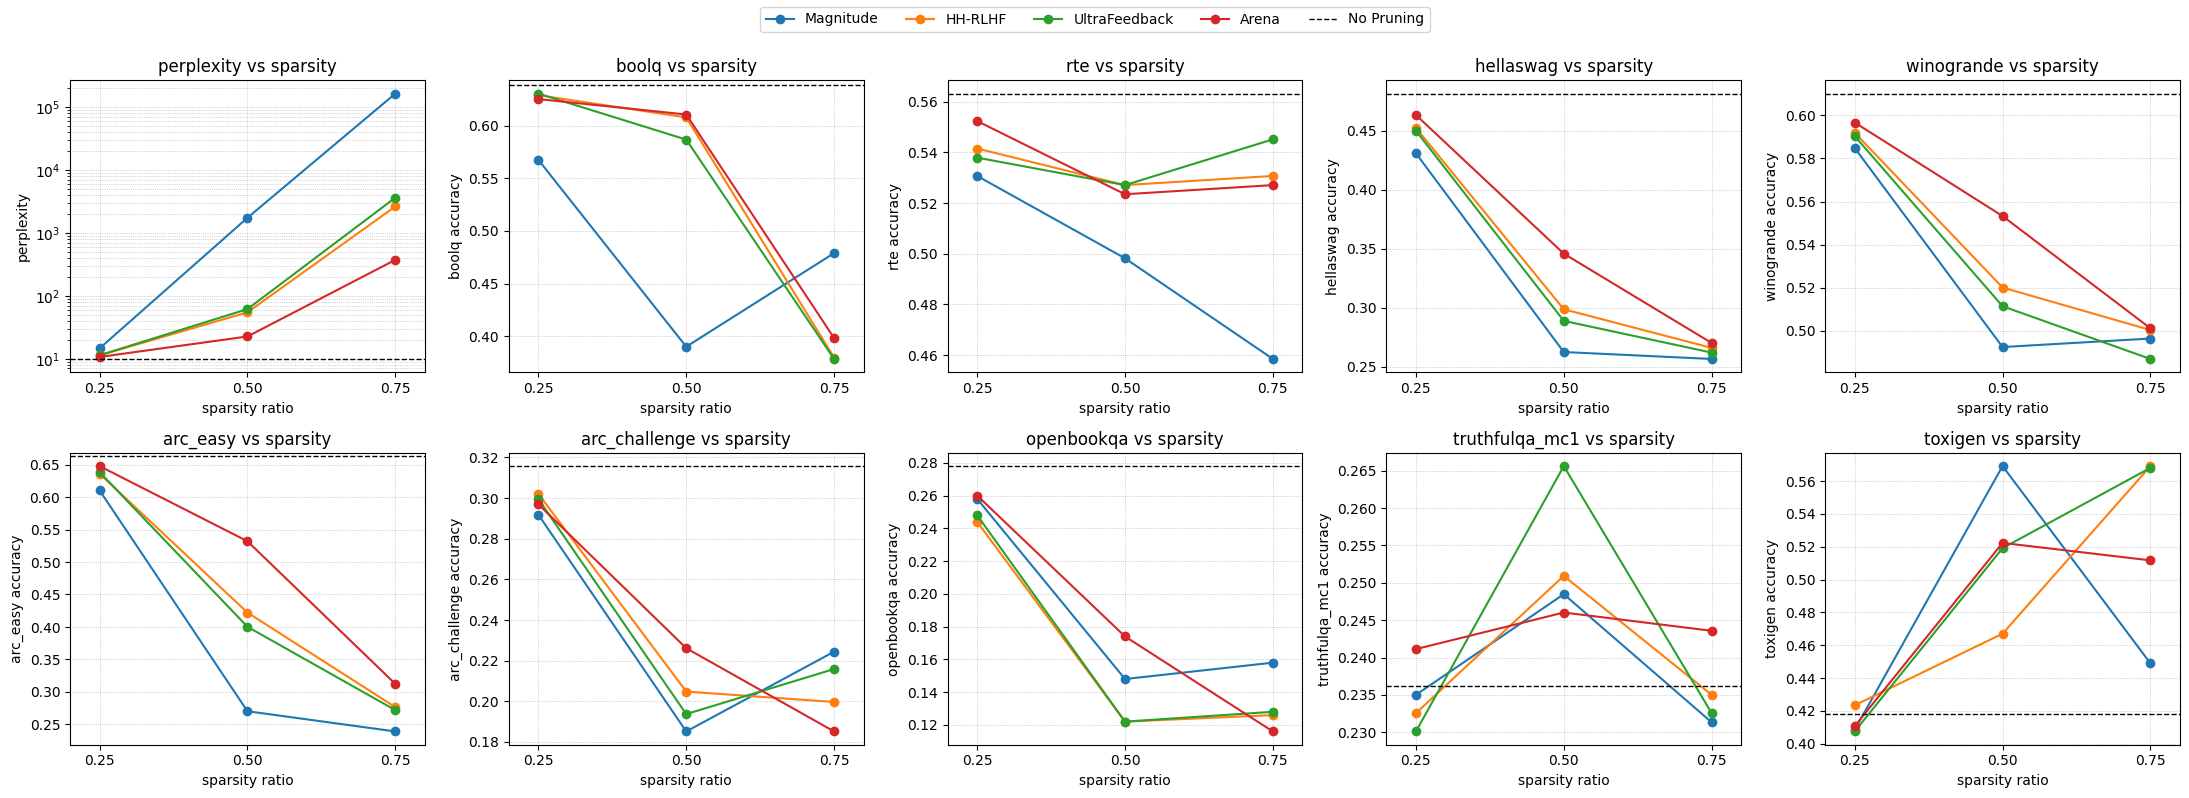

In [ ]:
import json
import matplotlib.pyplot as plt

# ---------- 1. Load JSON ----------
json_path = EVAL_FILE

with open(json_path, "r") as f:
    data = json.load(f)

# ---------- 2. Basic config ----------
method_keys = ["Magnitude", "HH", "UltraFeedback", "Arena"]
method_lables = {
    "Magnitude": "Magnitude",
    "HH": "HH-RLHF",
    "UltraFeedback": "UltraFeedback",
    "Arena": "Arena",
}

# Metrics: perplexity + all zero_shot entries except 'mean'
all_metrics = ["perplexity"] + GENERAL_TASKS + TREND_TASKS

# Baseline entry
baseline_key = "Llama_3_2_1B_0_Baseline"
baseline_entry = data[baseline_key]

# Helper to get metric value from an entry
def get_metric(entry, metric_name):
    if metric_name == "perplexity":
        return entry["perplexity"]
    if metric_name in GENERAL_TASKS:
        return entry["zero_shot"][metric_name]
    if metric_name in TREND_TASKS:
        return entry["trends"][metric_name]
    raise ValueError(f"Unknown metric: {metric_name}")

# ---------- 3. Large 2x5 canvas ----------
fig, axes = plt.subplots(2, 5, figsize=(22, 8))
axes = axes.flatten()  # make indexing easy

for i, metric in enumerate(all_metrics):
    ax = axes[i]

    # Plot each method as a line over sparsity
    for method in method_keys:
        y_vals = []
        for s in sparsity_levels:
            key = f"Llama_3_2_1B_{int(s*100)}_{method}"
            entry = data[key]
            y_vals.append(get_metric(entry, metric))

        ax.plot(
            sparsity_levels,
            y_vals,
            marker="o",
            label=method_lables[method],
        )

    # Baseline as horizontal line
    baseline_val = get_metric(baseline_entry, metric)
    ax.axhline(
        baseline_val,
        linestyle="--",
        color="black",
        label="No Pruning",
        linewidth=1,
    )

    ax.set_xlim(min(sparsity_levels) - 0.05, max(sparsity_levels) + 0.05)
    ax.set_xticks(sparsity_levels)

    if metric == "perplexity":
        ax.set_ylabel("perplexity")
        ax.set_yscale("log")
    else:
        ax.set_ylabel(f"{metric} accuracy")

    ax.set_xlabel("sparsity ratio")
    ax.set_title(f"{metric} vs sparsity")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# Hide unused panels if <10 metrics
for j in range(len(all_metrics), 10):
    fig.delaxes(axes[j])

# One shared legend (cleaner)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import json
import pandas as pd

# ---------- 1. Load JSON ----------
json_path = EVAL_FILE

with open(json_path, "r") as f:
    data = json.load(f)

# ---------- 2. Config ----------
MODEL_NAME_PRETTY = "Llama-3.2-1B"
MODEL_PREFIX = "Llama_3_2_1B"

TASKS_7 = [
    "boolq",
    "rte",
    "hellaswag",
    "arc_easy",
    "arc_challenge",
    "winogrande",
    "openbookqa",
]

# Only showing baseline + 50% block
SPARSITY_LEVELS = ["50"]

METHODS = {
    "Magnitude": "Magnitude",
    "HH": "HH",
    "UltraFeedback": "UF",
    "Arena": "Arena",
}

rows = []

# ---------- ✅ BASELINE ROW ----------
baseline_key = f"{MODEL_PREFIX}_0_Baseline"

if baseline_key in data:
    entry = data[baseline_key]

    row = {
        "model": MODEL_NAME_PRETTY,
        "sparsity": "0%",
        "method": "Baseline",
    }

    for task in TASKS_7:
        row[task] = entry["zero_shot"][task]

    row["mean"] = entry["zero_shot"]["mean"]

    rows.append(row)
else:
    print(f"[skip] missing {baseline_key}")

# ---------- ✅ 50% METHODS ----------
for sparsity in SPARSITY_LEVELS:
    for method_key, method_label in METHODS.items():
        key = f"{MODEL_PREFIX}_{sparsity}_{method_key}"

        if key not in data:
            print(f"[skip] missing {key}")
            continue

        entry = data[key]

        row = {
            "model": MODEL_NAME_PRETTY,
            "sparsity": f"{sparsity}%",
            "method": method_label,
        }

        for task in TASKS_7:
            row[task] = entry["zero_shot"][task]

        row["mean"] = entry["zero_shot"]["mean"]

        rows.append(row)

# ---------- 3. Sort nicely ----------
df = pd.DataFrame(rows)
df = df.sort_values(["sparsity", "method"])

# ---------- 4. Pretty grouped display ----------
df_grouped = df.set_index(["model", "sparsity", "method"])

# Markdown table
print(df_grouped.to_markdown(floatfmt=".2f"))

# LaTeX table
# print(df_grouped.to_latex(float_format="%.2f"))

|                                      |   boolq |   rte |   hellaswag |   arc_easy |   arc_challenge |   winogrande |   openbookqa |   mean |
|:-------------------------------------|--------:|------:|------------:|-----------:|----------------:|-------------:|-------------:|-------:|
| ('Llama-3.2-1B', '0%', 'Baseline')   |    0.64 |  0.56 |        0.48 |       0.66 |            0.32 |         0.61 |         0.28 |   0.51 |
| ('Llama-3.2-1B', '50%', 'Arena')     |    0.61 |  0.52 |        0.35 |       0.53 |            0.23 |         0.55 |         0.17 |   0.42 |
| ('Llama-3.2-1B', '50%', 'HH')        |    0.61 |  0.53 |        0.30 |       0.42 |            0.20 |         0.52 |         0.12 |   0.39 |
| ('Llama-3.2-1B', '50%', 'Magnitude') |    0.39 |  0.50 |        0.26 |       0.27 |            0.19 |         0.49 |         0.15 |   0.32 |
| ('Llama-3.2-1B', '50%', 'UF')        |    0.59 |  0.53 |        0.29 |       0.40 |            0.19 |         0.51 |         0.12 |   0.38 |

In [ ]:
import json
import pandas as pd

# ---------- 1. Load JSON ----------
json_path = EVAL_FILE

with open(json_path, "r") as f:
    data = json.load(f)

# ---------- 2. Config ----------
MODEL_NAME_PRETTY = "Llama-3.2-1B"
MODEL_PREFIX = "Llama_3_2_1B"

SPARSITY_LEVELS = ["50"]

METHODS = {
    "Magnitude": "Magnitude",
    "HH": "HH",
    "UltraFeedback": "UF",
    "Arena": "Arena",
}

# ---------- 3. Build perplexity row ----------
perplexity_row = {}

# ✅ Baseline column
baseline_key = f"{MODEL_PREFIX}_0_Baseline"

if baseline_key in data:
    perplexity_row["Baseline (0%)"] = data[baseline_key]["perplexity"]
else:
    print(f"[skip] missing {baseline_key}")

# ✅ 50% columns
for sparsity in SPARSITY_LEVELS:
    for method_key, method_label in METHODS.items():
        key = f"{MODEL_PREFIX}_{sparsity}_{method_key}"

        if key not in data:
            print(f"[skip] missing {key}")
            continue

        col_name = f"{method_label} ({sparsity}%)"
        perplexity_row[col_name] = data[key]["perplexity"]

# ---------- 4. Build DataFrame (one-row table) ----------
df = pd.DataFrame([perplexity_row], index=["Perplexity"])

# ---------- 5. Print ----------
print(df.to_markdown(floatfmt=".3f"))

# For LaTeX (paper-ready):
# print(df.to_latex(float_format="%.3f"))

# html = df.to_html(border=1, float_format="%.3f")
# print(html)

|            |   Baseline (0%) |   Magnitude (50%) |   HH (50%) |   UF (50%) |   Arena (50%) |
|:-----------|----------------:|------------------:|-----------:|-----------:|--------------:|
| Perplexity |           9.916 |          1732.262 |     54.618 |     61.442 |        22.561 |


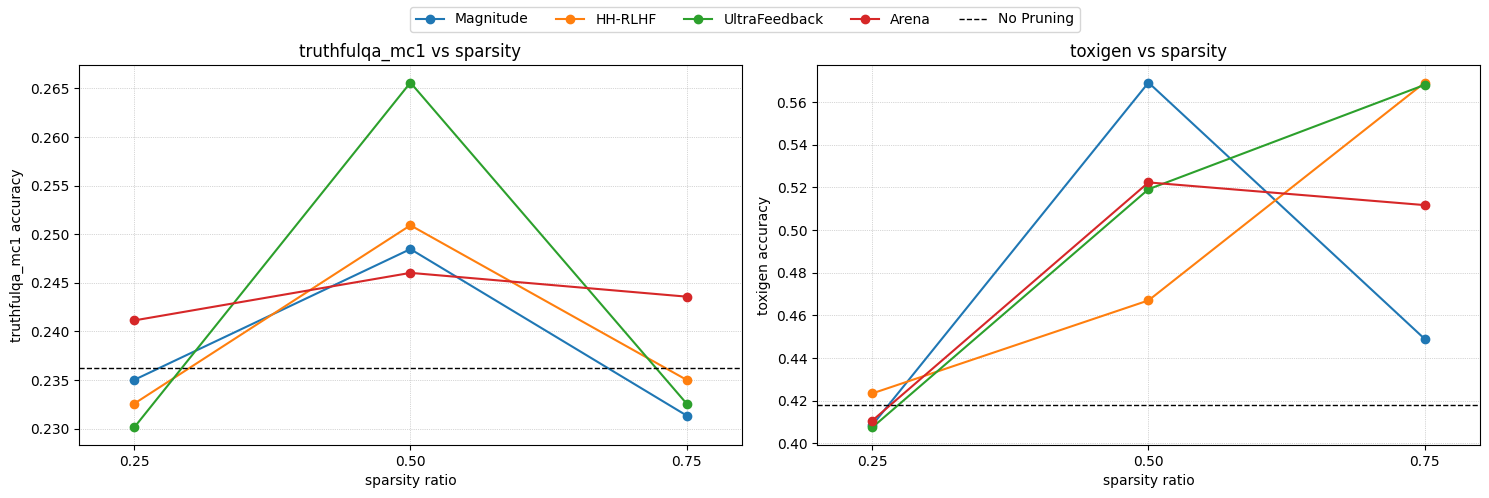

In [ ]:
import json
import matplotlib.pyplot as plt

# ---------- 1. Load JSON ----------
json_path = EVAL_FILE

with open(json_path, "r") as f:
    data = json.load(f)

# ---------- 2. Basic config ----------
method_keys = ["Magnitude", "HH", "UltraFeedback", "Arena"]
method_lables = {
    "Magnitude": "Magnitude",
    "HH": "HH-RLHF",
    "UltraFeedback": "UltraFeedback",
    "Arena": "Arena",
}

# Just the trend tasks (assumed length == 2)
all_metrics = TREND_TASKS

baseline_key = "Llama_3_2_1B_0_Baseline"
baseline_entry = data[baseline_key]

def get_metric(entry, metric_name):
    if metric_name == "perplexity":
        return entry["perplexity"]
    if metric_name in GENERAL_TASKS:
        return entry["zero_shot"][metric_name]
    if metric_name in TREND_TASKS:
        return entry["trends"][metric_name]
    raise ValueError(f"Unknown metric: {metric_name}")

# ---------- 3. Large 1 x 2 canvas ----------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, metric in enumerate(all_metrics):
    ax = axes[i]

    # Plot each method as a line over sparsity
    for method in method_keys:
        y_vals = []
        for s in sparsity_levels:  # assumes sparsity_levels is defined, e.g. [0.25, 0.5, 0.75]
            key = f"Llama_3_2_1B_{int(s*100)}_{method}"
            entry = data[key]
            y_vals.append(get_metric(entry, metric))

        ax.plot(
            sparsity_levels,
            y_vals,
            marker="o",
            label=method_lables[method],
        )

    # Baseline as horizontal line
    baseline_val = get_metric(baseline_entry, metric)
    ax.axhline(
        baseline_val,
        linestyle="--",
        color="black",
        label="No Pruning",
        linewidth=1,
    )

    ax.set_xlim(min(sparsity_levels) - 0.05, max(sparsity_levels) + 0.05)
    ax.set_xticks(sparsity_levels)

    ax.set_ylabel(f"{metric} accuracy")  # trend metric
    ax.set_xlabel("sparsity ratio")
    ax.set_title(f"{metric} vs sparsity")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


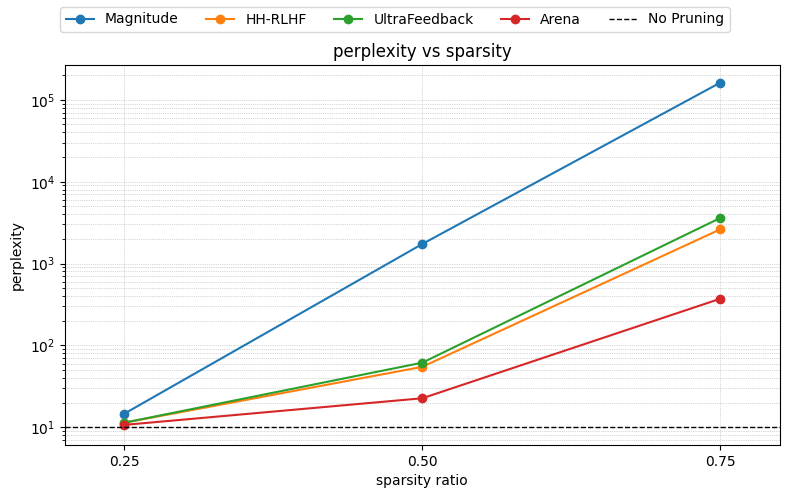

In [ ]:
import json
import matplotlib.pyplot as plt

# ---------- 1. Load JSON ----------
json_path = EVAL_FILE

with open(json_path, "r") as f:
    data = json.load(f)

# ---------- 2. Basic config ----------
method_keys = ["Magnitude", "HH", "UltraFeedback", "Arena"]
method_lables = {
    "Magnitude": "Magnitude",
    "HH": "HH-RLHF",
    "UltraFeedback": "UltraFeedback",
    "Arena": "Arena",
}

# Only perplexity
all_metrics = ["perplexity"]

baseline_key = "Llama_3_2_1B_0_Baseline"
baseline_entry = data[baseline_key]

def get_metric(entry, metric_name):
    if metric_name == "perplexity":
        return entry["perplexity"]
    if metric_name in GENERAL_TASKS:
        return entry["zero_shot"][metric_name]
    if metric_name in TREND_TASKS:
        return entry["trends"][metric_name]
    raise ValueError(f"Unknown metric: {metric_name}")

# ---------- 3. Single canvas ----------
fig, ax = plt.subplots(figsize=(8, 5))

for metric in all_metrics:  # here it's just "perplexity"
    # Plot each method as a line over sparsity
    for method in method_keys:
        y_vals = []
        for s in sparsity_levels:  # e.g. [0.25, 0.5, 0.75]
            key = f"Llama_3_2_1B_{int(s * 100)}_{method}"
            entry = data[key]
            y_vals.append(get_metric(entry, metric))

        ax.plot(
            sparsity_levels,
            y_vals,
            marker="o",
            label=method_lables[method],
        )

    # Baseline as horizontal line
    baseline_val = get_metric(baseline_entry, metric)
    ax.axhline(
        baseline_val,
        linestyle="--",
        color="black",
        label="No Pruning",
        linewidth=1,
    )

ax.set_xlim(min(sparsity_levels) - 0.05, max(sparsity_levels) + 0.05)
ax.set_xticks(sparsity_levels)

# Perplexity-specific styling
ax.set_ylabel("perplexity")
ax.set_yscale("log")

ax.set_xlabel("sparsity ratio")
ax.set_title("perplexity vs sparsity")
ax.grid(True, which="both", linestyle=":", linewidth=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()